In [1]:
#NOTE: use python env acmil in ACMIL folder
import sys
import os
import numpy as np
import openslide
import matplotlib.pyplot as plt

import matplotlib
matplotlib.use('Agg')
import pandas as pd
import warnings
import torch
import torch.nn as nn

from sklearn.model_selection import KFold, train_test_split
from torch.utils.data import DataLoader, Subset, ConcatDataset
import torch.optim as optim
from pathlib import Path
import PIL
from skimage import filters
import random

    
sys.path.insert(0, '../Utils/')
from Utils import create_dir_if_not_exists
from Utils import generate_deepzoom_tiles, extract_tile_start_end_coords, get_map_startend
from Utils import get_downsample_factor
from Utils import minmax_normalize, set_seed
from Utils import log_message
from Eval import compute_performance, plot_LOSS, compute_performance_each_label, get_attention_and_tileinfo, get_performance, plot_roc_curve
from train_utils import pull_tiles, FocalLoss
from train_utils import ModelReadyData_diffdim, convert_to_dict, prediction_sepatt, BCE_Weighted_Reg, BCE_Weighted_Reg_focal, compute_loss_for_all_labels_sepatt
from Model import Mutation_MIL_MT_sepAtt #, Mutation_MIL_MT
from ACMIL import ACMIL_GA_MultiTask, predict_v2, train_one_epoch_multitask, evaluate_multitask
warnings.filterwarnings("ignore")
%matplotlib inline


#FOR ACMIL
current_dir = os.getcwd()
grandparent_subfolder = os.path.join(current_dir, '..', '..', 'other_model_code','ACMIL-main')
grandparent_subfolder = os.path.normpath(grandparent_subfolder)
sys.path.insert(0, grandparent_subfolder)
from utils.utils import save_model, Struct, set_seed
import yaml
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
import yaml
from pprint import pprint

import argparse
import torch
from torch.utils.data import DataLoader

from utils.utils import save_model, Struct, set_seed
from datasets.datasets import build_HDF5_feat_dataset
from architecture.transformer import ACMIL_GA #ACMIL_GA
from architecture.transformer import ACMIL_MHA
import torch.nn.functional as F
import wandb

In [2]:
####################################
######      USERINPUT       ########
####################################
ALL_LABELS = ["AR","MMR (MSH2, MSH6, PMS2, MLH1, MSH3, MLH3, EPCAM)2","PTEN","RB1","TP53","TMB_HIGHorINTERMEDITATE","MSI_POS"]
TUMOR_FRAC_THRES = 0.9 
feature_extraction_method = 'uni2' #retccl, uni1
learning_method = "acmil"
focal_gamma = 20
focal_alpha = 0.95

#Best before
# focal_gamma = 2
# focal_alpha = 0.1
loss_method = 'Focal' #ATTLOSS

################################
#model Para
BATCH_SIZE  = 1
DROPOUT = 0
DIM_OUT = 128
SELECTED_MUTATION = "MT"
SELECTED_FOLD = 0
arch = 'ga_mt' #ga_mt or ga

if feature_extraction_method == 'retccl':
    SELECTED_FEATURE = [str(i) for i in range(0,2048)] + ['TUMOR_PIXEL_PERC'] #If retccl 2048, if uni 1024
    N_FEATURE = 2048
elif feature_extraction_method == 'uni1': 
    SELECTED_FEATURE = [str(i) for i in range(0,1024)] + ['TUMOR_PIXEL_PERC'] #If retccl 2048, if uni 1024
    N_FEATURE = 1024
elif feature_extraction_method == 'uni2':
    SELECTED_FEATURE = [str(i) for i in range(0,1536)] + ['TUMOR_PIXEL_PERC'] #If retccl 2048, if uni 1024
    N_FEATURE = 1536
    
################################
# get config
config_dir = "myconf.yml"
with open(config_dir, "r") as ymlfile:
    c = yaml.load(ymlfile, Loader=yaml.FullLoader)
    #c.update(vars(args))
    conf = Struct(**c)

conf.train_epoch = 200
conf.D_feat = N_FEATURE
conf.D_inner = DIM_OUT

if learning_method == 'abmil':
    conf.n_token = 1
    conf.mask_drop = 0
    conf.n_masked_patch = 0
elif learning_method == 'acmil':
    conf.n_token = 3
    conf.mask_drop = 0.6
    conf.n_masked_patch = 0
    
conf.n_class = 1
conf.wandb_mode = 'disabled'
conf.n_task = 7
#conf.lr = 0.000001 #change this for HR only

# Print all key-value pairs in the conf object
for key, value in conf.__dict__.items():
    print(f"{key}: {value}")
    
##################
###### DIR  ######
##################
proj_dir = '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/'
folder_name_overlap = "IMSIZE250_OL100"
folder_name_nonoverlap = "IMSIZE250_OL0"
feature_path_opx_train =  os.path.join(proj_dir + 'intermediate_data/5_model_ready_data', "OPX", folder_name_overlap, 'feature_' + feature_extraction_method, 'TFT' + str(TUMOR_FRAC_THRES))
feature_path_opx_test =  os.path.join(proj_dir + 'intermediate_data/5_model_ready_data', "OPX", folder_name_nonoverlap, 'feature_' + feature_extraction_method, 'TFT' + str(TUMOR_FRAC_THRES))
feature_path_tma = os.path.join(proj_dir + 'intermediate_data/5_model_ready_data', "TAN_TMA_Cores",folder_name_nonoverlap, 'feature_' + feature_extraction_method, 'TFT' + str(TUMOR_FRAC_THRES))
feature_path_tcga = os.path.join(proj_dir + 'intermediate_data/5_model_ready_data', "TCGA_PRAD",folder_name_nonoverlap, 'feature_' + feature_extraction_method, 'TFT' + str(TUMOR_FRAC_THRES))

folder_name_ids = 'uni1/TrainOL100_TestOL0_TFT' + str(TUMOR_FRAC_THRES)  + "/"
train_val_test_id_path =  os.path.join(proj_dir + 'intermediate_data/6_Train_TEST_IDS', folder_name_ids)

train_epoch: 200
warmup_epoch: 0
wd: 1e-05
lr: 0.0001
min_lr: 0
dataset: bracs
B: 1
n_class: 1
n_worker: 8
pin_memory: False
n_shot: -1
D_feat: 1536
D_inner: 128
n_token: 3
mask_drop: 0.6
n_masked_patch: 0
wandb_mode: disabled
n_task: 7


In [3]:
######################
#Create output-dir
################################################
folder_name1 = feature_extraction_method + '/TrainOL100_TestOL0_TFT' + str(TUMOR_FRAC_THRES)  + "/"
outdir0 =  proj_dir + "intermediate_data/pred_out03152025_ACMIL" + "/" + folder_name1 + 'FOLD' + str(SELECTED_FOLD) + '/' + SELECTED_MUTATION + "/" 
outdir1 =  outdir0  + "/saved_model/"
outdir2 =  outdir0  + "/model_para/"
outdir3 =  outdir0  + "/logs/"
outdir4 =  outdir0  + "/predictions/"
outdir5 =  outdir0  + "/perf/"


create_dir_if_not_exists(outdir0)
create_dir_if_not_exists(outdir1)
create_dir_if_not_exists(outdir2)
create_dir_if_not_exists(outdir3)
create_dir_if_not_exists(outdir4)
create_dir_if_not_exists(outdir5)

##################
#Select GPU
##################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out03152025_ACMIL/uni2/TrainOL100_TestOL0_TFT0.9/FOLD0/MT/' already exists.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out03152025_ACMIL/uni2/TrainOL100_TestOL0_TFT0.9/FOLD0/MT//saved_model/' already exists.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out03152025_ACMIL/uni2/TrainOL100_TestOL0_TFT0.9/FOLD0/MT//model_para/' already exists.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out03152025_ACMIL/uni2/TrainOL100_TestOL0_TFT0.9/FOLD0/MT//logs/' already exists.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out03152025_ACMIL/uni2/TrainOL100_TestOL0_TFT0.9/FOLD0/MT//predictions/' already exists.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out03152025_ACMIL/uni2/TrainOL100_TestOL0_TFT0.9/FOLD0/MT//perf/' already exists.
cuda:0


In [4]:
################################################
#     Model ready data 
################################################
opx_data_ol100 = torch.load(feature_path_opx_train + '/OPX_data.pth')
opx_ids_ol100 = torch.load(feature_path_opx_train + '/OPX_ids.pth')
opx_info_ol100  = torch.load(feature_path_opx_train + '/OPX_info.pth')

opx_data_ol0 = torch.load(feature_path_opx_test + '/OPX_data.pth')
opx_ids_ol0 = torch.load(feature_path_opx_test + '/OPX_ids.pth')
opx_info_ol0  = torch.load(feature_path_opx_test + '/OPX_info.pth')

tma_data = torch.load(feature_path_tma + '/tma_data.pth')
tma_ids = torch.load(feature_path_tma + '/tma_ids.pth')
tma_info  = torch.load(feature_path_tma + '/tma_info.pth')


tcga_data = torch.load(feature_path_tcga + '/TCGA_data.pth')
tcga_ids = torch.load(feature_path_tcga + '/TCGA_ids.pth')
tcga_info  = torch.load(feature_path_tcga + '/TCGA_info.pth')


########################################################
#Update tma
########################################################
haslabel_indexes = []
for i in range(len(tma_data)):
    if torch.isnan(tma_data[i][1]).all() == False:
        #print(f"Item {i} has the second element all NaNs.")
        haslabel_indexes.append(i)


tma_data = Subset(tma_data, haslabel_indexes)
tma_ids = list(Subset(tma_ids, haslabel_indexes))
tma_info = list(Subset(tma_info, haslabel_indexes))
len(tma_info) #355 if TF0.9, a lot of cores does not have enough cancer tiles > 0.9


################################################
#Get train, test IDs
#NOTE: this was in the old train: ['OPX_207','OPX_209','OPX_213','OPX_214','OPX_215']
################################################
train_test_val_id_df = pd.read_csv(train_val_test_id_path + "train_test_split.csv")
train_ids_all = list(train_test_val_id_df.loc[train_test_val_id_df['FOLD' + str(SELECTED_FOLD)] == 'TRAIN', 'SAMPLE_ID'])
test_ids_all = list(train_test_val_id_df.loc[train_test_val_id_df['FOLD' + str(SELECTED_FOLD)] == 'TEST', 'SAMPLE_ID'])
val_ids_all = list(train_test_val_id_df.loc[train_test_val_id_df['FOLD' + str(SELECTED_FOLD)] == 'VALID', 'SAMPLE_ID'])


################################################
#Get Train, test, val data
################################################
#Train:
inc_idx = [opx_ids_ol100.index(x) for x in train_ids_all]
train_data = Subset(opx_data_ol100, inc_idx)
train_ids =  list(Subset(opx_ids_ol100, inc_idx))
train_info = list(Subset(opx_info_ol100, inc_idx))

#Val:
inc_idx = [opx_ids_ol100.index(x) for x in val_ids_all]
val_data = Subset(opx_data_ol100, inc_idx)
val_ids =  list(Subset(opx_ids_ol100, inc_idx))
val_info = list(Subset(opx_info_ol100, inc_idx))

#Test:
inc_idx = [opx_ids_ol0.index(x) for x in test_ids_all]
test_data = Subset(opx_data_ol0, inc_idx)
test_ids =  list(Subset(opx_ids_ol0, inc_idx))
test_info = list(Subset(opx_info_ol0, inc_idx))

In [5]:
#count labels in train
train_label_counts = [dt[1] for dt in train_data]
train_label_counts = torch.concat(train_label_counts)
count_ones = (train_label_counts == 1).sum(dim=0)
print(count_ones)
perc_ones = count_ones/train_label_counts.shape[0] * 100
formatted_numbers = [f"{x.item():.1f}" for x in perc_ones]
print(formatted_numbers)

#count labels in test
test_label_counts = [dt[1] for dt in test_data]
test_label_counts = torch.concat(test_label_counts)
count_ones = (test_label_counts == 1).sum(dim=0)
print(count_ones)
perc_ones = count_ones/test_label_counts.shape[0] * 100
formatted_numbers = [f"{x.item():.1f}" for x in perc_ones]
print(formatted_numbers)

#count labels in tma
tma_label_counts = [dt[1] for dt in tma_data] 
tma_label_counts = torch.concat(tma_label_counts)
count_ones = (tma_label_counts == 1).sum(dim=0)
print(count_ones)
perc_ones = count_ones/tma_label_counts.shape[0] * 100
formatted_numbers = [f"{x.item():.1f}" for x in perc_ones]
print(formatted_numbers) #["AR","PTEN","RB1","TP53"


#count labels in tcga
tcga_label_counts = [dt[1] for dt in tcga_data] 
tcga_label_counts = torch.concat(tcga_label_counts)
count_ones = (tcga_label_counts == 1).sum(dim=0)
print(count_ones)
perc_ones = count_ones/tcga_label_counts.shape[0] * 100
formatted_numbers = [f"{x.item():.1f}" for x in perc_ones]
print(formatted_numbers) #["AR","PTEN","RB1","TP53"


print(len(train_data))
print(len(val_data))
print(len(test_data))
print(len(tma_data))
print(len(tcga_data))

####################################################
#Dataloader for training
####################################################
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(dataset=val_data, batch_size=BATCH_SIZE, shuffle=False)
tma_loader = DataLoader(dataset=tma_data, batch_size=BATCH_SIZE, shuffle=False)
tcga_loader = DataLoader(dataset=tcga_data, batch_size=BATCH_SIZE, shuffle=False)

tensor([15, 25, 32, 18, 55, 10,  9])
['10.0', '16.7', '21.3', '12.0', '36.7', '6.7', '6.0']
tensor([ 5,  7,  8,  4, 18,  7,  7])
['11.1', '15.6', '17.8', '8.9', '40.0', '15.6', '15.6']
tensor([216,   0, 119, 107, 178,   0,   0])
['60.8', '0.0', '33.5', '30.1', '50.1', '0.0', '0.0']
tensor([ 2, 34, 13,  3, 53,  0,  4])
['0.4', '7.6', '2.9', '0.7', '11.9', '0.0', '0.9']
150
8
45
355
447


In [6]:
####################################################
# define network
####################################################
if arch == 'ga':
    model = ACMIL_GA(conf, n_token=conf.n_token, n_masked_patch=conf.n_masked_patch, mask_drop= conf.mask_drop)
elif arch == 'ga_mt':
    model = ACMIL_GA_MultiTask(conf, n_token=conf.n_token, n_masked_patch=conf.n_masked_patch, mask_drop= conf.mask_drop, n_task = conf.n_task)
else:
    model = ACMIL_MHA(conf, n_token=conf.n_token, n_masked_patch=conf.n_masked_patch, mask_drop=conf.mask_drop)
model.to(device)

            
# Example usage:
criterion = FocalLoss(alpha=focal_alpha, gamma=focal_gamma, reduction='mean')

# define optimizer, lr not important at this point
optimizer0 = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, weight_decay=conf.wd)

ckpt_dir = outdir1 + SELECTED_MUTATION + "/"
create_dir_if_not_exists(ckpt_dir)

Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out03152025_ACMIL/uni2/TrainOL100_TestOL0_TFT0.9/FOLD0/MT//saved_model/MT/' already exists.


In [7]:
from utils.utils import MetricLogger, SmoothedValue, adjust_learning_rate
def train_one_epoch_multitask(model, criterion, data_loader, optimizer0, device, epoch, conf, loss_method = 'none'):
    """
    Trains the given network for one epoch according to given criterions (loss functions)
    """

    # Set the network to training mode
    model.train()

    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)
    print_freq = 100


    for data_it, data in enumerate(metric_logger.log_every(data_loader, print_freq, header)):
        # for data_it, data in enumerate(data_loader, start=epoch * len(data_loader)):
        # Move input batch onto GPU if eager execution is enabled (default), else leave it on CPU
        # Data is a dict with keys `input` (patches) and `{task_name}` (labels for given task)
        image_patches = data[0].to(device, dtype=torch.float32)
        label_lists = data[1][0]
        tf = data[2].to(device, dtype=torch.float32)

        # # Calculate and set new learning rate
        adjust_learning_rate(optimizer0, epoch + data_it/len(data_loader), conf)

        # Compute loss
        sub_preds_list, slide_preds_list, attn_list = model(image_patches) #lists len of n of tasks, each task = [5,2], [1,2], [1,5,3],
        
        #Compute loss for each task, then sum
        loss = 0
        for k in range(conf.n_task):
            sub_preds = sub_preds_list[k]
            slide_preds = slide_preds_list[k]
            attn = attn_list[k]
            labels = label_lists[:,k].to(device, dtype = torch.float32).to(device)
                    
            if conf.n_token > 1:
                loss0 = criterion(sub_preds, labels.repeat_interleave(conf.n_token).unsqueeze(1))
            else:
                loss0 = torch.tensor(0.)
            loss1 = criterion(slide_preds, labels.unsqueeze(1))

            diff_loss = torch.tensor(0).to(device, dtype=torch.float)
            attn = torch.softmax(attn, dim=-1)
            
            for i in range(conf.n_token):
                for j in range(i + 1, conf.n_token):
                    diff_loss += torch.cosine_similarity(attn[:, i], attn[:, j], dim=-1).mean() / (
                                conf.n_token * (conf.n_token - 1) / 2)

            if loss_method == 'ATTLOSS': #ATTLOSS
                #ATT loss
                # avg_attn = attn.mean(dim = 1) #Across tokens
                # loss2 = F.mse_loss(avg_attn, tf)
                #for each token
                att_loss = 0
                for i in range(conf.n_token):
                    att_loss += F.mse_loss(attn[:,i,:], tf)
                loss += att_loss  + loss0 + loss1 
            else:
                loss += diff_loss + loss0 + loss1 

        optimizer0.zero_grad()
        # Backpropagate error and update parameters
        loss.backward()
        optimizer0.step()


        metric_logger.update(lr=optimizer0.param_groups[0]['lr'])
        metric_logger.update(sub_loss=loss0.item())
        metric_logger.update(diff_loss=diff_loss.item())
        metric_logger.update(slide_loss=loss1.item())

        if conf.wandb_mode != 'disabled':
            """ We use epoch_1000x as the x-axis in tensorboard.
            This calibrates different curves when batch size changes.
            """
            wandb.log({'sub_loss': loss0}, commit=False)
            wandb.log({'diff_loss': diff_loss}, commit=False)
            wandb.log({'slide_loss': loss1})
            #wandb.log({'att_loss': loss2})

In [8]:
####################################################
#            Train 
####################################################
set_seed(0)
loss_method = ''
# define optimizer, lr not important at this point
optimizer0 = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, weight_decay=conf.wd)
best_state = {'epoch':-1, 'val_acc':0, 'val_auc':0, 'val_f1':0, 'test_acc':0, 'test_auc':0, 'test_f1':0}
train_epoch = conf.train_epoch
for epoch in range(train_epoch):
    train_one_epoch_multitask(model, criterion, train_loader, optimizer0, device, epoch, conf, loss_method)
    val_auc, val_acc, val_f1, val_loss = evaluate_multitask(model, criterion, val_loader, device, conf, 'Val')
    test_auc, test_acc, test_f1, test_loss = evaluate_multitask(model, criterion, test_loader, device, conf, 'Test')
    #tma_auc, tma_acc, tma_f1, tma_loss = evaluate_multitask(model, criterion, tma_loader, device, conf, 'TMA')

    save_model(conf=conf, model=model, optimizer=optimizer0, epoch=epoch,
        save_path=os.path.join(ckpt_dir + 'checkpoint_' + 'epoch' + str(epoch) + '.pth'))
print("Results on best epoch:")
print(best_state)
wandb.finish()

Epoch: [0]  [  0/150]  eta: 0:01:11  lr: 0.000100  sub_loss: 0.0000 (0.0000)  diff_loss: 0.9999 (0.9999)  slide_loss: 0.0000 (0.0000)  time: 0.4771  data: 0.0006  max mem: 26
Epoch: [0]  [100/150]  eta: 0:00:01  lr: 0.000100  sub_loss: 0.0000 (0.0000)  diff_loss: 0.7467 (0.9424)  slide_loss: 0.0000 (0.0000)  time: 0.0236  data: 0.0013  max mem: 900
Epoch: [0]  [149/150]  eta: 0:00:00  lr: 0.000100  sub_loss: 0.0000 (0.0000)  diff_loss: 0.4614 (0.8274)  slide_loss: 0.0000 (0.0000)  time: 0.0244  data: 0.0018  max mem: 900
Epoch: [0] Total time: 0:00:04 (0.0282 s / it)
Val  [0/8]  eta: 0:00:00  loss: 0.0000 (0.0000)  div_loss: -44.7884 (-44.7884)  acc1: 100.0000 (100.0000)  time: 0.0055  data: 0.0006  max mem: 900
Val  [7/8]  eta: 0:00:00  loss: 0.0000 (0.0001)  div_loss: -30.4561 (-30.6116)  acc1: 85.7143 (89.2857)  time: 0.0041  data: 0.0002  max mem: 900
Val Total time: 0:00:00 (0.0042 s / it)
AUROC 0 : 0.0
AUROC 1 : 0.9999999403953552
AUROC 2 : 0.3333333432674408
AUROC 3 : 0.0
AUROC 

In [9]:
####################################################
#            Test 
####################################################
# # define network
# if arch == 'ga':
#     model2 = ACMIL_GA(conf, n_token=conf.n_token, n_masked_patch=conf.n_masked_patch, mask_drop= conf.mask_drop)
# elif arch == 'ga_mt':
#     model2 = ACMIL_GA_MultiTask(conf, n_token=conf.n_token, n_masked_patch=conf.n_masked_patch, mask_drop= conf.mask_drop, n_task = conf.n_task)
# else:
#     model2 = ACMIL_MHA(conf, n_token=conf.n_token, n_masked_patch=conf.n_masked_patch, mask_drop=conf.mask_drop)
# model2.to(device)

# # Load the checkpoint
# #checkpoint = torch.load(ckpt_dir + 'checkpoint-best.pth')
# checkpoint = torch.load(ckpt_dir + 'checkpoint_epoch99.pth')

# # Load the state_dict into the model
# model2.load_state_dict(checkpoint['model'])


y_pred_tasks_test, y_predprob_task_test, y_true_task_test = predict_v2(model, test_loader, device, conf, 'Test')
pred_df_list = []
perf_df_list = []
for i in range(conf.n_task):
    pred_df, perf_df = get_performance(y_predprob_task_test[i], y_true_task_test[i], test_ids, ALL_LABELS[i], THRES = 0.5)
    pred_df_list.append(pred_df)
    perf_df_list.append(perf_df)

all_perd_df = pd.concat(pred_df_list)
all_perf_df = pd.concat(perf_df_list)
print(all_perf_df)

all_perd_df.to_csv(outdir4 + "/n_token" + str(conf.n_token) + "_TEST_pred_df.csv",index = False)
all_perf_df.to_csv(outdir5 + "/n_token" + str(conf.n_token) + "_TEST_perf.csv",index = True)
print(round(all_perf_df['AUC'].mean(),2))

               AUC  Recall  Specificity   ACC  Precision    PR_AUC    F1  \
SAMPLE_LEVEL  0.68    0.40         0.68  0.64       0.13  0.203072  0.20   
SAMPLE_LEVEL  0.65    0.57         0.68  0.67       0.25  0.336017  0.35   
SAMPLE_LEVEL  0.65    1.00         0.43  0.53       0.28  0.340680  0.43   
SAMPLE_LEVEL  0.57    0.25         0.68  0.64       0.07  0.120184  0.11   
SAMPLE_LEVEL  0.58    0.72         0.22  0.42       0.38  0.538711  0.50   
SAMPLE_LEVEL  0.75    0.29         0.87  0.78       0.29  0.309926  0.29   
SAMPLE_LEVEL  0.83    0.43         0.97  0.89       0.75  0.522050  0.55   

                F2    F3                                           OUTCOME  
SAMPLE_LEVEL  0.29  0.33                                                AR  
SAMPLE_LEVEL  0.45  0.51  MMR (MSH2, MSH6, PMS2, MLH1, MSH3, MLH3, EPCAM)2  
SAMPLE_LEVEL  0.66  0.79                                              PTEN  
SAMPLE_LEVEL  0.17  0.20                                               RB1  
SAMPLE

In [24]:
pred_msi = all_perd_df.loc[all_perd_df['OUTCOME'] == 'MSI_POS']
pred_msi

,SAMPLE_IDs,Y_True,Pred_Prob,OUTCOME,Pred_Class
0,OPX_012,0,0.510742,MSI_POS,1
1,OPX_018,0,0.463804,MSI_POS,0
2,OPX_019,0,0.425398,MSI_POS,0
3,OPX_021,0,0.453008,MSI_POS,0
4,OPX_035,0,0.438791,MSI_POS,0
5,OPX_052,0,0.452419,MSI_POS,0
6,OPX_064,0,0.494214,MSI_POS,0
7,OPX_065,0,0.455436,MSI_POS,0
8,OPX_074,0,0.462157,MSI_POS,0
9,OPX_075,1,0.478020,MSI_POS,0


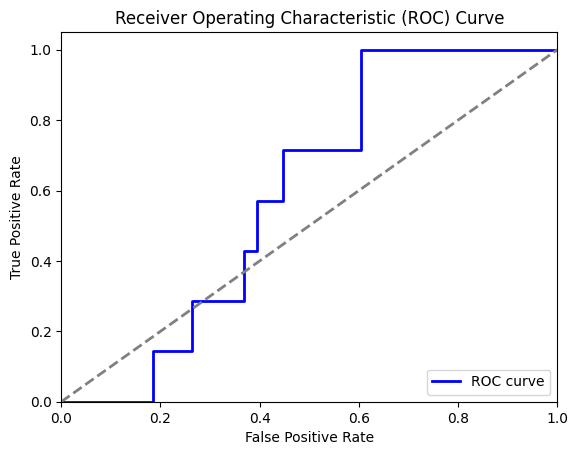

In [25]:
plot_roc_curve(list(pred_msi['Pred_Prob']),list(pred_msi['Y_True']))

In [12]:
# #PLOT:
# pred_df = all_perd_df
# SELECTED_LABEL = ['MSI_POS']
# #Get True Postives
# true_postive_ids = {}
# for label in SELECTED_LABEL:
#     cond = (pred_df['Y_True'] == pred_df['Pred_Class']) & (pred_df['Y_True'] == 1) & (pred_df['OUTCOME'] == label)
#     cur_pred_df = pred_df.loc[cond]
#     cur_ids = list(cur_pred_df['SAMPLE_IDs'])
#     true_postive_ids[label] = cur_ids

# #Get true nagative
# true_negative_ids = {}
# for label in SELECTED_LABEL:
#     cond = (pred_df['Y_True'] == pred_df['Pred_Class']) & (pred_df['Y_True'] == 0) & (pred_df['OUTCOME'] == label)
#     cur_pred_df = pred_df.loc[cond]
#     cur_ids = list(cur_pred_df['SAMPLE_IDs'])
#     true_negative_ids[label] = cur_ids

In [13]:
# ####################################################################################
# #Atention scores
# ####################################################################################
# save_image_size = 250
# pixel_overlap = 0
# mag_extract = 20
# limit_bounds = True
# TOP_K = 5
# pretrain_model_name = "retccl"
# mag_target_prob = 2.5
# smooth = True
# mag_target_tiss = 1.25

# def get_attention_and_tileinfo(pt_label_df, patient_att_score):    
#     #Get label
#     pt_label_df.reset_index(drop = True, inplace = True)

#     #Get attention
#     cur_att  = pd.DataFrame({'ATT':list(minmax_normalize(patient_att_score))})
#     cur_att.reset_index(drop = True, inplace = True)

#     #Comb
#     cur_att_df = pd.concat([pt_label_df,cur_att], axis = 1)
#     cur_att_df.reset_index(drop = True, inplace = True)

#     return cur_att_df

In [14]:
# attn[label_index].shape

In [15]:
# selected_ids = true_postive_ids[SELECTED_LABEL[0]]
# wsi_path = proj_dir + '/data/OPX/'
# branches = 1

# for pt in selected_ids:
#     i = test_ids.index(pt)
#     pt = test_ids[i]
#     print(pt)

#     save_location = outdir4 + SELECTED_LABEL[0] + "/"
#     save_location =  save_location  + pt + "/"
#     create_dir_if_not_exists(save_location)
    
#     _file = wsi_path + pt + ".tif"
#     oslide = openslide.OpenSlide(_file)
#     save_name = str(Path(os.path.basename(_file)).with_suffix(''))
    
#     first_batch = list(test_loader)[i]
#     feat = first_batch[0].to(device)
#     sub_preds, slide_preds, attn = model(feat)
#     #cur_pt_att =  attn[0,:,:].mean(0).cpu().detach().numpy() #Take the mean across branches without softmax
#     label_index = ALL_LABELS.index(SELECTED_LABEL[0])
#     cur_pt_att = attn[label_index][branches].mean(0).cpu().detach().numpy()
#     #branches = 0
#     #cur_pt_att = torch.softmax(attn, dim=-1)[0][branches].cpu().detach().numpy() 
    
#     #Get all tile info include noncancer tile
#     alltileinfo_dir = proj_dir + 'intermediate_data/TODELETE_cancer_prediction_results110224/' + "IMSIZE250_OL0" + "/"
#     tile_info_df = pd.read_csv(alltileinfo_dir + pt + "/"  + save_name + "_tiles.csv")
#     cur_pt_info = test_info[i]
#     #Combine current pt_info an all tile info
#     #cur_pt_info = tile_info_df.merge(cur_pt_info, on = list(tile_info_df.columns), how = "left")
    
#     cur_att_df = get_attention_and_tileinfo(cur_pt_info, cur_pt_att)
#     #cur_att_df.loc[pd.isna(cur_att_df['ATT']),'ATT'] = 0.0001
    
#     #Generate tiles
#     tiles, tile_lvls, physSize, base_mag = generate_deepzoom_tiles(oslide,save_image_size, pixel_overlap, limit_bounds)
    
#     #get level 0 size in px
#     l0_w = oslide.level_dimensions[0][0]
#     l0_h = oslide.level_dimensions[0][1]
    
#     #1.25x tissue detection for mask
#     from Utils import get_downsample_factor, get_image_at_target_mag
#     from Utils import do_mask_original,check_tissue,whitespace_check
#     import cv2
#     if 'OPX' in pt:
#         rad_tissue = 5
#     elif '(2017-0133)' in pt:
#         rad_tissue = 2
#     lvl_resize_tissue = get_downsample_factor(base_mag,target_magnification = mag_target_tiss) #downsample factor
#     lvl_img = get_image_at_target_mag(oslide,l0_w, l0_h,lvl_resize_tissue)
#     tissue, he_mask = do_mask_original(lvl_img, lvl_resize_tissue, rad = rad_tissue)
    
#     #2.5x for probability maps
#     lvl_resize = get_downsample_factor(base_mag,target_magnification = mag_target_prob) #downsample factor
#     x_map = np.zeros((int(np.ceil(l0_h/lvl_resize)),int(np.ceil(l0_w/lvl_resize))), float)
#     x_count = np.zeros((int(np.ceil(l0_h/lvl_resize)),int(np.ceil(l0_w/lvl_resize))), float)
    
    
#     for index, row in cur_att_df.iterrows():
#         cur_xy = row['TILE_XY_INDEXES'].strip("()").split(", ")
#         x ,y = int(cur_xy[0]) , int(cur_xy[1])
        
#         #Extract tile for prediction
#         lvl_in_deepzoom = tile_lvls.index(mag_extract)
#         tile_starts, tile_ends, save_coords, tile_coords = extract_tile_start_end_coords(tiles, lvl_in_deepzoom, x, y) #get tile coords
#         map_xstart, map_xend, map_ystart, map_yend = get_map_startend(tile_starts,tile_ends,lvl_resize) #Get current tile position in map
    
#         #Store predicted probabily in map and count
#         try: 
#             x_count[map_xstart:map_xend,map_ystart:map_yend] += 1
#             x_map[map_xstart:map_xend,map_ystart:map_yend] += row['ATT']
#         except:
#             pass
    
#     print('post-processing')
#     x_count = np.where(x_count < 1, 1, x_count)
#     x_map = x_map / x_count
#     x_map[x_map>1]=1
    
#     #Get the following before smooth
#     he_mask = cv2.resize(np.uint8(he_mask),(x_map.shape[1],x_map.shape[0])) #resize to output image size
#     cond1 = he_mask < 1 #Background
#     cond2 = (he_mask == 1) & (x_map == 0) #is tissue, but not selected
#     smooth = True
    
#     if smooth == True:
#         #x_sm = filters.gaussian(x_map, sigma=0)
#         x_sm = np.where(x_map != 0, filters.gaussian(x_map, sigma=10), x_map)
#     if smooth == False:
#         x_sm = x_map
    
#     #TODO:
#     #get cancer_mask:
#     # cancer_mask == 
#     # x_sm[(he_mask == 1) & (x_sm == 0)] = 0.1 #If tissue map value > 1, then x_sm = 1
#     x_sm[cond1] = 0 #Background
#     x_sm[cond2] = 0.1 #Is tissue, but not selected 
    
#     # Define the colors for the sequential colormap (black to fluorescent green)
#     colors = ["#4B0082", "#39FF14"]  # Black to Fluorescent Green
#     # Create the sequential colormap
#     cmap_name = "black_to_fluorescent_green"
#     from matplotlib.colors import LinearSegmentedColormap
#     from matplotlib.colors import ListedColormap
#     sequential_cmap = LinearSegmentedColormap.from_list(cmap_name, colors)
#     cmap =  plt.cm.Spectral_r #sequential_cmap # plt.cm.YlGn_r
#     cmap_colors = cmap(np.arange(cmap.N))
#     cmap_colors[0] = np.array([0.95, 0.95, 0.95, 1]) #np.array([1, 1, 1, 1])  # Set the first color (corresponding to 0) to white
#     cmap_colors[1] = np.array([0, 0, 0.545, 1])  # RGB for dark blue
#     custom_cmap = ListedColormap(cmap_colors)
    
#     plt.imshow(x_sm, cmap=custom_cmap) #Spectral_r
#     plt.colorbar()
#     plt.savefig(os.path.join(save_location, save_name + '_attention.png'), dpi=500,bbox_inches='tight')
#     plt.show()
#     plt.close()


#     #Top attented tiles
#     save_location2 = save_location + "top_tiles/"
#     create_dir_if_not_exists(save_location2)
    
#     #Get a Attention, and corresponding tiles
#     cur_att_df= cur_att_df.sort_values(by = ['ATT'], ascending = False) 
#     cur_pulled_img_obj = pull_tiles(cur_att_df.iloc[0:TOP_K], tiles, tile_lvls)
            
#     for i in range(TOP_K):
#         cur_pulled_img = cur_pulled_img_obj[i][0] #image
#         cur_pulled_att = cur_pulled_img_obj[i][1] #attentiom
#         cur_pulled_coord = cur_pulled_img_obj[i][2].strip("()").split(", ")  #att tile map coordiates
#         coord_save_name = '[xs' + cur_pulled_coord[0] + '_xe' + cur_pulled_coord[1] + '_ys' + cur_pulled_coord[2] + '_ye' + cur_pulled_coord[3] + "]"
#         tile_save_name = "ATT" + str(round(cur_pulled_att,2)) + "_MAPCOORD" +  coord_save_name +  ".png"
#         cur_pulled_img.save(os.path.join(save_location2, tile_save_name))
    
#     #Bot attented tiles
#     save_location2 = save_location + "bot_tiles/"
#     create_dir_if_not_exists(save_location2)
    
#     #Get a Attention, and corresponding tiles
#     cur_att_df= cur_att_df.sort_values(by = ['ATT'], ascending = True) 
#     cur_pulled_img_obj = pull_tiles(cur_att_df.iloc[0:TOP_K], tiles, tile_lvls)
    
#     for i in range(TOP_K):
#         cur_pulled_img = cur_pulled_img_obj[i][0] #image
#         cur_pulled_att = cur_pulled_img_obj[i][1] #attentiom
#         cur_pulled_coord = cur_pulled_img_obj[i][2].strip("()").split(", ")  #att tile map coordiates
#         coord_save_name = '[xs' + cur_pulled_coord[0] + '_xe' + cur_pulled_coord[1] + '_ys' + cur_pulled_coord[2] + '_ye' + cur_pulled_coord[3] + "]"
#         tile_save_name = "ATT" + str(round(cur_pulled_att,2)) + "_MAPCOORD" +  coord_save_name +  ".png"
#         cur_pulled_img.save(os.path.join(save_location2, tile_save_name))

In [16]:
##############################################################################################################################
# TMA
##############################################################################################################################
y_pred_tasks_test, y_predprob_task_test, y_true_task_test = predict_v2(model, tma_loader, device, conf, 'TMA')
pred_df_list = []
perf_df_list = []
for i in range(conf.n_task): 
    if i not in [1,5,6]:
        pred_df, perf_df = get_performance(y_predprob_task_test[i], y_true_task_test[i], tma_ids, ALL_LABELS[i],THRES = 0.5)
        pred_df_list.append(pred_df)
        perf_df_list.append(perf_df)

all_perd_df = pd.concat(pred_df_list)
all_perf_df = pd.concat(perf_df_list)
print(all_perf_df)
all_perd_df.to_csv(outdir4 + "/n_token" + str(conf.n_token) + "_TMA_pred_df.csv",index = False)
all_perf_df.to_csv(outdir5 + "/n_token" + str(conf.n_token) + "_TMA_perf.csv",index = True)
print(round(all_perf_df['AUC'].mean(),2))

               AUC  Recall  Specificity   ACC  Precision    PR_AUC    F1  \
SAMPLE_LEVEL  0.53    0.29         0.73  0.46       0.62  0.611493  0.40   
SAMPLE_LEVEL  0.37    0.66         0.21  0.36       0.30  0.281050  0.41   
SAMPLE_LEVEL  0.57    0.51         0.59  0.57       0.35  0.374346  0.42   
SAMPLE_LEVEL  0.53    0.98         0.06  0.52       0.51  0.533337  0.67   

                F2    F3 OUTCOME  
SAMPLE_LEVEL  0.33  0.31      AR  
SAMPLE_LEVEL  0.53  0.59    PTEN  
SAMPLE_LEVEL  0.47  0.49     RB1  
SAMPLE_LEVEL  0.83  0.90    TP53  
0.5


In [17]:
##############################################################################################################################
# TCGA
##############################################################################################################################
y_pred_tasks_test, y_predprob_task_test, y_true_task_test = predict_v2(model, tcga_loader, device, conf, 'TCGA')
pred_df_list = []
perf_df_list = []
for i in range(conf.n_task):
    if i != 5 :
        pred_df, perf_df = get_performance(y_predprob_task_test[i], y_true_task_test[i], tcga_ids, ALL_LABELS[i], THRES = 0.5)
        pred_df_list.append(pred_df)
        perf_df_list.append(perf_df)
all_perd_df = pd.concat(pred_df_list)
all_perf_df = pd.concat(perf_df_list)
print(all_perf_df)
all_perd_df.to_csv(outdir4 + "/n_token" + str(conf.n_token) + "_TCGA_pred_df.csv",index = False)
all_perf_df.to_csv(outdir5 + "/n_token" + str(conf.n_token) + "_TCGA_perf.csv",index = True)
print(round(all_perf_df['AUC'].mean(),2))

               AUC  Recall  Specificity   ACC  Precision    PR_AUC    F1  \
SAMPLE_LEVEL  0.87    0.50         0.93  0.93       0.03  0.042593  0.06   
SAMPLE_LEVEL  0.58    0.26         0.83  0.79       0.11  0.137587  0.16   
SAMPLE_LEVEL  0.49    0.62         0.18  0.19       0.02  0.037275  0.04   
SAMPLE_LEVEL  0.40    0.00         0.96  0.95       0.00  0.009386  0.00   
SAMPLE_LEVEL  0.57    0.77         0.22  0.28       0.12  0.154417  0.20   
SAMPLE_LEVEL  0.89    0.25         0.96  0.95       0.05  0.302386  0.09   

                F2    F3                                           OUTCOME  
SAMPLE_LEVEL  0.12  0.20                                                AR  
SAMPLE_LEVEL  0.21  0.23  MMR (MSH2, MSH6, PMS2, MLH1, MSH3, MLH3, EPCAM)2  
SAMPLE_LEVEL  0.10  0.17                                              PTEN  
SAMPLE_LEVEL  0.00  0.00                                               RB1  
SAMPLE_LEVEL  0.37  0.50                                              TP53  
SAMPL

In [18]:
# #PLOT:
# pred_df = all_perd_df
# SELECTED_LABEL = ['MSI_POS']
# #Get True Postives
# true_postive_ids = {}
# for label in SELECTED_LABEL:
#     cond = (pred_df['Y_True'] == pred_df['Pred_Class']) & (pred_df['Y_True'] == 1) & (pred_df['OUTCOME'] == label)
#     cur_pred_df = pred_df.loc[cond]
#     cur_ids = list(cur_pred_df['SAMPLE_IDs'])
#     true_postive_ids[label] = cur_ids

# #Get true nagative
# true_negative_ids = {}
# for label in SELECTED_LABEL:
#     cond = (pred_df['Y_True'] == pred_df['Pred_Class']) & (pred_df['Y_True'] == 0) & (pred_df['OUTCOME'] == label)
#     cur_pred_df = pred_df.loc[cond]
#     cur_ids = list(cur_pred_df['SAMPLE_IDs'])
#     true_negative_ids[label] = cur_ids

In [19]:
# ####################################################################################
# #Atention scores
# ####################################################################################
# save_image_size = 250
# pixel_overlap = 0
# mag_extract = 20
# limit_bounds = True
# TOP_K = 5
# pretrain_model_name = "retccl"
# mag_target_prob = 2.5
# smooth = True
# mag_target_tiss = 1.25

# def get_attention_and_tileinfo(pt_label_df, patient_att_score):    
#     #Get label
#     pt_label_df.reset_index(drop = True, inplace = True)

#     #Get attention
#     cur_att  = pd.DataFrame({'ATT':list(minmax_normalize(patient_att_score))})
#     cur_att.reset_index(drop = True, inplace = True)

#     #Comb
#     cur_att_df = pd.concat([pt_label_df,cur_att], axis = 1)
#     cur_att_df.reset_index(drop = True, inplace = True)

#     return cur_att_df

In [20]:
#print(attn[label_index].shape)

In [21]:
# selected_ids = true_postive_ids[SELECTED_LABEL[0]]
# wsi_path = proj_dir + '/data/TCGA_PRAD/'
# branches = 0

# for pt in selected_ids:
#     i = tcga_ids.index(pt)
#     pt = tcga_ids[i]
#     print(pt)

#     save_location = outdir4 + SELECTED_LABEL[0] + "/"
#     save_location =  save_location  + pt + "/"
#     create_dir_if_not_exists(save_location)

#     slides_name = [f for f in os.listdir(wsi_path + pt + '/') if '.svs' in f][0].replace('.svs','')
#     _file = wsi_path + pt + '/' + slides_name + '.svs'
#     oslide = openslide.OpenSlide(_file)
#     save_name = str(Path(os.path.basename(_file)).with_suffix(''))
    
#     first_batch = list(tcga_loader)[i]
#     feat = first_batch[0].to(device)
#     sub_preds, slide_preds, attn = model(feat)
#     label_index = ALL_LABELS.index(SELECTED_LABEL[0])
#     #cur_pt_att = attn[label_index][:,:,:].mean(1).cpu().detach().numpy() #mean across all branchs
#     cur_pt_att = attn[label_index][:,branches,:].mean(0).cpu().detach().numpy()
#     #branches = 0
#     #cur_pt_att = torch.softmax(attn[label_index], dim=1).cpu().detach().numpy() 
    
#     #Get all tile info include noncancer tile    
#     alltileinfo_dir = proj_dir + 'intermediate_data/1_tile_pulling/TCGA_PRAD/' + "IMSIZE250_OL0" + "/"
#     tile_info_df = pd.read_csv(alltileinfo_dir + pt + "/"  + save_name + "_tiles.csv")
#     cur_pt_info = tcga_info[i]
#     #Combine current pt_info an all tile info
#     #cur_pt_info = tile_info_df.merge(cur_pt_info, on = list(tile_info_df.columns), how = "left")
    
#     cur_att_df = get_attention_and_tileinfo(cur_pt_info, cur_pt_att)
#     #cur_att_df.loc[pd.isna(cur_att_df['ATT']),'ATT'] = 0.0001
    
#     #Generate tiles
#     tiles, tile_lvls, physSize, base_mag = generate_deepzoom_tiles(oslide,save_image_size, pixel_overlap, limit_bounds)
    
#     #get level 0 size in px
#     l0_w = oslide.level_dimensions[0][0]
#     l0_h = oslide.level_dimensions[0][1]
    
#     #1.25x tissue detection for mask
#     from Utils import get_downsample_factor, get_image_at_target_mag
#     from Utils import do_mask_original,check_tissue,whitespace_check
#     import cv2
#     if 'OPX' in pt:
#         rad_tissue = 5
#     elif '(2017-0133)' in pt:
#         rad_tissue = 2
#     else:
#         rad_tissue = 2
#     lvl_resize_tissue = get_downsample_factor(base_mag,target_magnification = mag_target_tiss) #downsample factor
#     lvl_img = get_image_at_target_mag(oslide,l0_w, l0_h,lvl_resize_tissue)
#     tissue, he_mask = do_mask_original(lvl_img, lvl_resize_tissue, rad = rad_tissue)
    
#     #2.5x for probability maps
#     lvl_resize = get_downsample_factor(base_mag,target_magnification = mag_target_prob) #downsample factor
#     x_map = np.zeros((int(np.ceil(l0_h/lvl_resize)),int(np.ceil(l0_w/lvl_resize))), float)
#     x_count = np.zeros((int(np.ceil(l0_h/lvl_resize)),int(np.ceil(l0_w/lvl_resize))), float)
    
    
#     for index, row in cur_att_df.iterrows():
#         cur_xy = row['TILE_XY_INDEXES'].strip("()").split(", ")
#         x ,y = int(cur_xy[0]) , int(cur_xy[1])
        
#         #Extract tile for prediction
#         lvl_in_deepzoom = tile_lvls.index(mag_extract)
#         tile_starts, tile_ends, save_coords, tile_coords = extract_tile_start_end_coords(tiles, lvl_in_deepzoom, x, y) #get tile coords
#         map_xstart, map_xend, map_ystart, map_yend = get_map_startend(tile_starts,tile_ends,lvl_resize) #Get current tile position in map
    
#         #Store predicted probabily in map and count
#         try: 
#             x_count[map_xstart:map_xend,map_ystart:map_yend] += 1
#             x_map[map_xstart:map_xend,map_ystart:map_yend] += row['ATT']
#         except:
#             pass
    
#     print('post-processing')
#     x_count = np.where(x_count < 1, 1, x_count)
#     x_map = x_map / x_count
#     x_map[x_map>1]=1
    
#     #Get the following before smooth
#     he_mask = cv2.resize(np.uint8(he_mask),(x_map.shape[1],x_map.shape[0])) #resize to output image size
#     cond1 = he_mask < 1 #Background
#     cond2 = (he_mask == 1) & (x_map == 0) #is tissue, but not selected
#     smooth = True
    
#     if smooth == True:
#         #x_sm = filters.gaussian(x_map, sigma=0)
#         x_sm = np.where(x_map != 0, filters.gaussian(x_map, sigma=10), x_map)
#     if smooth == False:
#         x_sm = x_map
    
#     #TODO:
#     #get cancer_mask:
#     # cancer_mask == 
#     # x_sm[(he_mask == 1) & (x_sm == 0)] = 0.1 #If tissue map value > 1, then x_sm = 1
#     x_sm[cond1] = 0 #Background
#     x_sm[cond2] = 0.1 #Is tissue, but not selected 
    
#     # Define the colors for the sequential colormap (black to fluorescent green)
#     colors = ["#4B0082", "#39FF14"]  # Black to Fluorescent Green
#     # Create the sequential colormap
#     cmap_name = "black_to_fluorescent_green"
#     from matplotlib.colors import LinearSegmentedColormap
#     from matplotlib.colors import ListedColormap
#     sequential_cmap = LinearSegmentedColormap.from_list(cmap_name, colors)
#     cmap =  plt.cm.Spectral_r #sequential_cmap # plt.cm.YlGn_r
#     cmap_colors = cmap(np.arange(cmap.N))
#     cmap_colors[0] = np.array([0.95, 0.95, 0.95, 1]) #np.array([1, 1, 1, 1])  # Set the first color (corresponding to 0) to white
#     cmap_colors[1] = np.array([0, 0, 0.545, 1])  # RGB for dark blue
#     custom_cmap = ListedColormap(cmap_colors)
    
#     plt.imshow(x_sm, cmap=custom_cmap) #Spectral_r
#     plt.colorbar()
#     plt.savefig(os.path.join(save_location, save_name + '_attention.png'), dpi=500,bbox_inches='tight')
#     plt.show()
#     plt.close()


#     #Top attented tiles
#     save_location2 = save_location + "top_tiles/"
#     create_dir_if_not_exists(save_location2)
    
#     #Get a Attention, and corresponding tiles
#     cur_att_df= cur_att_df.sort_values(by = ['ATT'], ascending = False) 
#     cur_pulled_img_obj = pull_tiles(cur_att_df.iloc[0:TOP_K], tiles, tile_lvls)
            
#     for i in range(TOP_K):
#         cur_pulled_img = cur_pulled_img_obj[i][0] #image
#         cur_pulled_att = cur_pulled_img_obj[i][1] #attentiom
#         cur_pulled_coord = cur_pulled_img_obj[i][2].strip("()").split(", ")  #att tile map coordiates
#         coord_save_name = '[xs' + cur_pulled_coord[0] + '_xe' + cur_pulled_coord[1] + '_ys' + cur_pulled_coord[2] + '_ye' + cur_pulled_coord[3] + "]"
#         tile_save_name = "ATT" + str(round(cur_pulled_att,2)) + "_MAPCOORD" +  coord_save_name +  ".png"
#         cur_pulled_img.save(os.path.join(save_location2, tile_save_name))
    
#     #Bot attented tiles
#     save_location2 = save_location + "bot_tiles/"
#     create_dir_if_not_exists(save_location2)
    
#     #Get a Attention, and corresponding tiles
#     cur_att_df= cur_att_df.sort_values(by = ['ATT'], ascending = True) 
#     cur_pulled_img_obj = pull_tiles(cur_att_df.iloc[0:TOP_K], tiles, tile_lvls)
    
#     for i in range(TOP_K):
#         cur_pulled_img = cur_pulled_img_obj[i][0] #image
#         cur_pulled_att = cur_pulled_img_obj[i][1] #attentiom
#         cur_pulled_coord = cur_pulled_img_obj[i][2].strip("()").split(", ")  #att tile map coordiates
#         coord_save_name = '[xs' + cur_pulled_coord[0] + '_xe' + cur_pulled_coord[1] + '_ys' + cur_pulled_coord[2] + '_ye' + cur_pulled_coord[3] + "]"
#         tile_save_name = "ATT" + str(round(cur_pulled_att,2)) + "_MAPCOORD" +  coord_save_name +  ".png"
#         cur_pulled_img.save(os.path.join(save_location2, tile_save_name))